# Excel to Pandas: Housing Market Edition

**Using Real Zillow Research Data**

___
*Estimated Time: ~60 minutes*
___

Contents:

- Introduction: Why Transition from Excel to Pandas?
- Setting Up: Loading Real Zillow Data
    - Understanding the Wide Format
    - Reshaping with pd.melt() — Excel's "Unpivot"
- Basic Data Operations
    - Reading Data
    - Viewing and Inspecting Data
- Excel Functions Translated to Pandas
    - VLOOKUP/XLOOKUP → merge() and map()
    - FILTER → Boolean Indexing
    - SUMIF/COUNTIF → Conditional Aggregations
    - IF Statements → np.where() and apply()
- Advanced Operations
    - PIVOT TABLES → pivot_table() and groupby()
    - JOINs → merge() with home_values + rent_values datasets
- Data Visualization
    - Bar Charts
    - Line Charts
- Interactive Widgets and Practice
- Exercises
- Conclusion

In [10]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML, Markdown
from interact import (
    explore_data_widget,
    filter_markets_widget,
    pivot_table_widget,
    metro_trends_widget,
)
import warnings
warnings.filterwarnings('ignore')

# Set plot style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✅ All libraries imported successfully!")
print("\n📌 Note: This notebook uses interactive widgets (ipywidgets)")
print("   You'll see dropdowns and sliders throughout — just run each cell and use the controls!")

✅ All libraries imported successfully!

📌 Note: This notebook uses interactive widgets (ipywidgets)
   You'll see dropdowns and sliders throughout — just run each cell and use the controls!


# Introduction: Why Transition from Excel to Pandas?

Excel is a powerful tool for data analysis, but it has limitations:

- **Scale**: Excel struggles with datasets larger than ~1 million rows
- **Reproducibility**: Manual operations are hard to document and reproduce
- **Automation**: Repetitive tasks require VBA or manual effort
- **Version Control**: Tracking changes is difficult

**Pandas**, a Python library, addresses these issues:

- Handles millions of rows efficiently
- All operations are code-based and reproducible
- Easy to automate workflows
- Integrates with version control systems (Git)
- Free and open-source

In this notebook, you'll learn how to translate your Excel skills into Pandas using **real housing market data** from Zillow Research!

## Key Concept: DataFrames vs Spreadsheets

In Excel, you work with **worksheets** containing cells organized in rows and columns.

In Pandas, you work with **DataFrames** — similar structure but with powerful programmatic capabilities:

| Excel Concept | Pandas Equivalent |
|--------------|------------------|
| Workbook | Multiple DataFrames |
| Worksheet | DataFrame |
| Column | Series (`df['column_name']`) |
| Row | Row (`df.loc[row_index]`) |
| Cell | Single value (`df.loc[row, col]`) |

---

# Setting Up: Loading Real Zillow Data

We'll work with two real datasets published by [Zillow Research](https://www.zillow.com/research/data/):

1. **home_values (Zillow Home Value Index)** — the typical home value by metro area, monthly, going back to 2000
2. **home_values (Zillow Observed Rent Index)** — the typical observed rent by metro area, monthly

These are the same datasets analysts at real estate firms and banks use for housing market research.

**Load Zillow Home Value Index (home_values)**
- Excel: File → Open → Browse → select the CSV
- Pandas: use `pd.read_csv()` with a URL or file path
- Also load the rent_values rent dataset for the same metros

In [11]:
# URLs from https://www.zillow.com/research/data/
zhvi_URL = (
    "https://files.zillowstatic.com/research/public_csvs/zhvi/"
    "Metro_zhvi_uc_sfrcondo_tier_0.33_0.67_sm_sa_month.csv"
)
zori_URL = (
    "https://files.zillowstatic.com/research/public_csvs/zori/"
    "Metro_zori_uc_sfrcondomfr_sm_month.csv"
)

print("⏳ Downloading home value data (ZHVI) from Zillow Research...")
home_values_wide = pd.read_csv(zhvi_URL)
print(f"✅ Home values loaded: {home_values_wide.shape[0]} metro areas × {home_values_wide.shape[1]} columns")

print("\n⏳ Downloading rent data (ZORI) from Zillow Research...")
rent_values_wide = pd.read_csv(zori_URL)
print(f"✅ Rent values loaded: {rent_values_wide.shape[0]} metro areas × {rent_values_wide.shape[1]} columns")

⏳ Downloading home value data (ZHVI) from Zillow Research...
✅ Home values loaded: 895 metro areas × 318 columns

⏳ Downloading rent data (ZORI) from Zillow Research...
✅ Rent values loaded: 721 metro areas × 138 columns


In [12]:
# Let's look at what the raw home value data looks like
print("Raw home value data (first 5 rows, first 10 columns):")
display(home_values_wide.iloc[:5, :10])

print("\n📌 Notice the structure:")
print("  • Each ROW = one metro area (e.g., 'Los Angeles, CA')")
print("  • Each COLUMN after StateName = a monthly date (e.g., '2000-01-31')")
print("  • Each VALUE = the typical home value in $ for that metro + month")
print(f"\n  Total date columns: {home_values_wide.shape[1] - 5}")

Raw home value data (first 5 rows, first 10 columns):


,RegionID,SizeRank,RegionName,RegionType,StateName,2000-01-31,2000-02-29,2000-03-31,2000-04-30,2000-05-31
0,102001,0,United States,country,NaN,120245.401273,120456.951481,120719.304889,121282.001451,121929.597731
1,394913,1,"New York, NY",msa,NY,216213.074441,217131.858016,218059.151183,219938.205956,221884.032245
2,753899,2,"Los Angeles, CA",msa,CA,219357.633964,220173.922681,221261.211467,223424.550904,225790.566038
3,394463,3,"Chicago, IL",msa,IL,149975.869412,150114.703378,150379.115111,151036.905792,151828.148861
4,394514,4,"Dallas, TX",msa,TX,126453.868825,126510.191820,126574.940868,126743.087346,126964.783873



📌 Notice the structure:
  • Each ROW = one metro area (e.g., 'Los Angeles, CA')
  • Each COLUMN after StateName = a monthly date (e.g., '2000-01-31')
  • Each VALUE = the typical home value in $ for that metro + month

  Total date columns: 313


### 💡 Understanding the 'Wide' Format

The Zillow CSV is in **wide format** — each date is its own column. This is common in Excel:

| RegionName | 2000-01-31 | 2000-02-29 | 2000-03-31 | ... |
|------------|-----------|-----------|-----------|-----|
| Los Angeles, CA | 210,000 | 212,000 | 214,000 | ... |
| New York, NY | 350,000 | 351,000 | 353,000 | ... |

For most pandas analysis, we need **long format** — each row is one observation (metro + date + value):

| RegionName | Date | HomeValue |
|------------|------|-----------|
| Los Angeles, CA | 2000-01-31 | 210,000 |
| Los Angeles, CA | 2000-02-29 | 212,000 |
| New York, NY | 2000-01-31 | 350,000 |

**Excel Equivalent**: Data → Get & Transform → Unpivot Columns  
**Pandas Equivalent**: `pd.melt()`

**Excel 'Unpivot' → `pd.melt()`**
- In Excel: Data → Get & Transform → Unpivot Columns
- In pandas: use `pd.melt` to reshape wide date columns into rows
- Keep metadata columns as identifiers and unpivot the date columns

In [13]:
# Identify the metadata columns (non-date columns)
meta_cols = ['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName']

# Identify the date columns (everything else)
date_cols = [c for c in home_values_wide.columns if c not in meta_cols]

print(f"Metadata columns: {meta_cols}")
print(f"Number of date columns: {len(date_cols)}")
print(f"Date range: {date_cols[0]} → {date_cols[-1]}")

home_values = pd.melt(
    home_values_wide,
    id_vars=meta_cols,        # columns to KEEP as-is
    value_vars=date_cols,     # columns to UNPIVOT into rows
    var_name='Date',          # name for the new 'column header' column
    value_name='HomeValue'    # name for the new 'value' column
)

# Convert Date string to an actual datetime object
home_values['Date'] = pd.to_datetime(home_values['Date'])

# Drop rows where HomeValue is missing (some early months have no data)
home_values = home_values.dropna(subset=['HomeValue'])

print(f"\n✅ Reshaped to long format: {home_values.shape[0]:,} rows × {home_values.shape[1]} columns")
print("\nFirst 5 rows of long-format data:")
display(home_values.head())

# Backwards-compatible alias used elsewhere in the notebook
home_values = home_values

Metadata columns: ['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName']
Number of date columns: 313
Date range: 2000-01-31 → 2026-01-31

✅ Reshaped to long format: 230,869 rows × 7 columns

First 5 rows of long-format data:


,RegionID,SizeRank,RegionName,RegionType,StateName,Date,HomeValue
0,102001,0,United States,country,NaN,2000-01-31,120245.401273
1,394913,1,"New York, NY",msa,NY,2000-01-31,216213.074441
2,753899,2,"Los Angeles, CA",msa,CA,2000-01-31,219357.633964
3,394463,3,"Chicago, IL",msa,IL,2000-01-31,149975.869412
4,394514,4,"Dallas, TX",msa,TX,2000-01-31,126453.868825


In [14]:
# Do the same for rent_values (rent data)
rent_meta_cols = ['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName']
rent_date_cols = [c for c in rent_values_wide.columns if c not in rent_meta_cols]

rent_values = pd.melt(
    rent_values_wide,
    id_vars=rent_meta_cols,
    value_vars=rent_date_cols,
    var_name='Date',
    value_name='Rent'
)
rent_values['Date'] = pd.to_datetime(rent_values['Date'])
rent_values = rent_values.dropna(subset=['Rent'])

print(f"✅ rent_values long format (rent values): {rent_values.shape[0]:,} rows × {rent_values.shape[1]} columns")
display(rent_values.head())

✅ rent_values long format (rent values): 48,768 rows × 7 columns


,RegionID,SizeRank,RegionName,RegionType,StateName,Date,Rent
0,102001,0,United States,country,NaN,2015-01-31,1136.875660
1,394913,1,"New York, NY",msa,NY,2015-01-31,2147.623068
2,753899,2,"Los Angeles, CA",msa,CA,2015-01-31,1745.689589
3,394463,3,"Chicago, IL",msa,IL,2015-01-31,1343.902521
4,394514,4,"Dallas, TX",msa,TX,2015-01-31,1045.936211


### Column definitions (long-format data)

**home_values** (Zillow Home Value Index, one row per metro per month):

- **RegionID** — Zillow’s unique numeric ID for the region.
- **SizeRank** — Rank by market size (0 = largest, e.g. United States or New York; higher = smaller market).
- **RegionName** — Name of the metro or area (e.g. "New York, NY", "Los Angeles, CA").
- **RegionType** — Geography type: `country` (e.g. United States), or `msa` = **Metropolitan Statistical Area** (a core city plus surrounding counties the U.S. government groups as one economic region; “metro” in the data means MSA).
- **StateName** — State code (e.g. NY, CA); missing for U.S. or non-state regions.
- **Date** — Month of the observation (month-end date).
- **HomeValue** — Typical home value in dollars (ZHVI, smoothed, seasonally adjusted, mid-tier).

**rent_values** (Zillow Observed Rent Index, one row per metro per month):

- **RegionID** — Zillow’s unique numeric ID for the region.
- **SizeRank** — Rank by market size (0 = largest).
- **RegionName** — Name of the metro or area.
- **RegionType** — Geography type: `country` or `msa` (Metropolitan Statistical Area; see above).
- **StateName** — State code; missing for U.S. or non-state regions.
- **Date** — Month of the observation.
- **Rent** — Typical observed monthly rent in dollars (ZORI, smoothed).

---

# Basic Data Operations

## Reading and Inspecting Data

In Excel, you open a file by clicking it. In Pandas, you use `read_csv()`.

**Excel**: File → Open → Browse → Select file  
**Pandas**: `df = pd.read_csv('filename.csv')` or `df = pd.read_csv('https://...')`

### Essential Inspection Methods

| Excel Action | Pandas Method | Purpose |
|-------------|--------------|--------|
| Scroll to see data | `df.head()` or `df.tail()` | View first/last rows |
| Ctrl+Down to see size | `df.shape` | Get (rows, columns) |
| Right-click column header | `df.info()` | See column types and non-null counts |
| Select column → look at status bar | `df.describe()` | Get summary statistics |

In [15]:
# Interactive widget to explore different inspection methods
explore_data_widget(home_values)

interactive(children=(Dropdown(description='method', options=('head() — first 5 rows', 'tail() — last 5 rows',…

---

# Excel Functions Translated to Pandas

## 1. VLOOKUP / XLOOKUP → merge() and map()

**VLOOKUP** looks up a value in one table and pulls a column from another table.

**Excel Formula**: `=VLOOKUP(RegionName, RentTable, RentColumn, FALSE)`

**Pandas Equivalent**: `df.merge()` — joins two DataFrames like a SQL JOIN

We'll use this to attach rent data (rent_values) to home value data (home_values) for the same metro areas.

**Using `map()` as a simpler VLOOKUP**
- Goal: build a dictionary from `RegionName` to latest `HomeValue`
- Use `.map()` to attach that lookup value to each row
- Equivalent to an Excel VLOOKUP returning a single column

In [16]:
# Find the most recent date in the dataset
latest_date = home_values['Date'].max()
print(f"Most recent month in dataset: {latest_date.strftime('%B %Y')}")

# Create a dictionary mapping RegionName → latest HomeValue
# This is like building a lookup table in Excel
latest_values = (
    home_values[home_values['Date'] == latest_date]
    .set_index('RegionName')['HomeValue']
    .to_dict()
)

print(f"\nSample entries from our lookup dictionary:")
sample_keys = list(latest_values.keys())[:5]
for k in sample_keys:
    print(f"  {k}: ${latest_values[k]:,.0f}")

# Now apply it to the full dataset using map()
# Excel equivalent: =VLOOKUP(A2, LookupTable, 2, FALSE)
latest_home_values = home_values[home_values['Date'] == latest_date].copy()
latest_home_values['NationalRank'] = latest_home_values['SizeRank']

# Backwards-compatible name used elsewhere in the notebook
home_values_latest = latest_home_values

print("\nUsing map() to rank markets by size:")
display(latest_home_values[['RegionName', 'StateName', 'HomeValue', 'NationalRank']]
        .sort_values('NationalRank')
        .head(10))

Most recent month in dataset: January 2026

Sample entries from our lookup dictionary:
  United States: $357,445
  New York, NY: $703,126
  Los Angeles, CA: $943,674
  Chicago, IL: $333,939
  Dallas, TX: $357,649

Using map() to rank markets by size:


,RegionName,StateName,HomeValue,NationalRank
279240,United States,NaN,357444.592267,0
279241,"New York, NY",NY,703126.246109,1
279242,"Los Angeles, CA",CA,943673.884613,2
279243,"Chicago, IL",IL,333939.343216,3
279244,"Dallas, TX",TX,357649.079207,4
279245,"Houston, TX",TX,302328.791293,5
279246,"Washington, DC",VA,567376.572421,6
279247,"Philadelphia, PA",PA,374293.019263,7
279248,"Miami, FL",FL,466840.612008,8
279249,"Atlanta, GA",GA,373624.931003,9


**Using `merge()` as a full VLOOKUP**
- Goal: combine latest home values and rents for each metro
- Start from home_values (home values) and join rent_values (rents) on `RegionName`
- Keep all metros from home_values and fill missing rents with `NaN`

In [17]:
latest_rent_values = rent_values[rent_values['Date'] == rent_values['Date'].max()][['RegionName', 'Rent']]
latest_home_snapshot = home_values[home_values['Date'] == latest_date][['RegionName', 'StateName', 'HomeValue', 'SizeRank']]

# This is like doing =VLOOKUP(RegionName, rent_valuesTable, RentColumn, FALSE)
# but getting ALL columns from the rent table at once
housing = latest_home_snapshot.merge(
    latest_rent_values,
    on='RegionName',
    how='left'  # Keep all metros from the home value table, fill NaN if no rent data
)

print(f"Merged dataset shape: {housing.shape}")
print("\nHousing data with home values AND rents:")
display(housing.dropna().sort_values('SizeRank').head(10))

Merged dataset shape: (895, 5)

Housing data with home values AND rents:


,RegionName,StateName,HomeValue,SizeRank,Rent
1,"New York, NY",NY,703126.246109,1,3232.316444
2,"Los Angeles, CA",CA,943673.884613,2,2884.813189
3,"Chicago, IL",IL,333939.343216,3,2091.226250
4,"Dallas, TX",TX,357649.079207,4,1632.977977
5,"Houston, TX",TX,302328.791293,5,1611.789280
6,"Washington, DC",VA,567376.572421,6,2333.437240
7,"Philadelphia, PA",PA,374293.019263,7,1849.206515
8,"Miami, FL",FL,466840.612008,8,2645.074918
9,"Atlanta, GA",GA,373624.931003,9,1811.803598
10,"Boston, MA",MA,709007.938766,10,3048.713676


### 💡 map() vs merge() — When to Use Which?

| Situation | Use |
|-----------|-----|
| You need ONE value from a lookup table | `map()` |
| You need MULTIPLE columns from another table | `merge()` |
| You want SQL-style join behavior (inner, outer, left) | `merge()` |
| Fastest option for a simple single-column lookup | `map()` |

---

## 2. FILTER → Boolean Indexing

**FILTER** in Excel (or AutoFilter) selects rows that meet a condition.

**Excel**: Data → Filter → select criteria  
**Pandas**: `df[condition]` — called **Boolean Indexing**

**Simple filter: California metros only**
- Excel: AutoFilter on `StateName = 'CA'`
- Pandas: subset rows where `StateName` equals `'CA'`
- Then sort metros by `HomeValue` descending

In [18]:
ca_metros = latest_home_values[latest_home_values['StateName'] == 'CA']

print(f"California metros: {len(ca_metros)}")
display(ca_metros[['RegionName', 'HomeValue']].sort_values('HomeValue', ascending=False))

California metros: 34


,RegionName,HomeValue
279275,"San Jose, CA",1.568567e+06
279419,"Santa Cruz, CA",1.091457e+06
279252,"San Francisco, CA",1.089769e+06
279361,"Santa Maria, CA",9.708079e+05
279242,"Los Angeles, CA",9.436739e+05
279257,"San Diego, CA",9.043125e+05
279411,"San Luis Obispo, CA",8.798271e+05
279543,"Napa, CA",8.672771e+05
279310,"Oxnard, CA",8.621272e+05
279362,"Salinas, CA",8.262509e+05


**Multi-condition filters**
- AND condition: CA metros with `HomeValue > 800000`
- OR condition: metros in TX or FL
- Use `&` and `|` with boolean expressions in pandas

In [19]:
expensive_ca = latest_home_values[
    (latest_home_values['StateName'] == 'CA') &
    (latest_home_values['HomeValue'] > 800_000)
]
print("CA metros with home values > $800K:")
display(expensive_ca[['RegionName', 'HomeValue']].sort_values('HomeValue', ascending=False))

tx_fl = latest_home_values[
    (latest_home_values['StateName'] == 'TX') |
    (latest_home_values['StateName'] == 'FL')
]
print(f"\nTX or FL metros: {len(tx_fl)}")
display(tx_fl[['RegionName', 'StateName', 'HomeValue']].sort_values('HomeValue', ascending=False).head(10))

CA metros with home values > $800K:


,RegionName,HomeValue
279275,"San Jose, CA",1.568567e+06
279419,"Santa Cruz, CA",1.091457e+06
279252,"San Francisco, CA",1.089769e+06
279361,"Santa Maria, CA",9.708079e+05
279242,"Los Angeles, CA",9.436739e+05
279257,"San Diego, CA",9.043125e+05
279411,"San Luis Obispo, CA",8.798271e+05
279543,"Napa, CA",8.672771e+05
279310,"Oxnard, CA",8.621272e+05
279362,"Salinas, CA",8.262509e+05



TX or FL metros: 96


,RegionName,StateName,HomeValue
279669,"Key West, FL",FL,933558.173334
279384,"Naples, FL",FL,551179.504660
280053,"Fredericksburg, TX",TX,494867.628557
279248,"Miami, FL",FL,466840.612008
279412,"Crestview, FL",FL,427868.045592
279269,"Austin, TX",TX,419518.286799
279312,"North Port, FL",FL,399919.514302
279560,"The Villages, FL",FL,386919.123365
279262,"Orlando, FL",FL,380501.021945
279352,"Port St. Lucie, FL",FL,375394.589896


**Filtering for multiple values with `isin()`**
- Mimic Excel's AutoFilter with multiple checked states
- Define a list of target states like CA, NY, TX, FL, WA
- Use `df['StateName'].isin(target_states)` to select matching rows

In [20]:
# Interactive Filter Widget
filter_markets_widget(latest_home_values)

interactive(children=(Dropdown(description='state_choice', options=('All', 'AK', 'AL', 'AR', 'AZ', 'CA', 'CO',…

---

## 3. SUMIF / COUNTIF → Conditional Aggregations

**SUMIF** and **COUNTIF** calculate totals or counts based on conditions.

**Excel Formula**: `=AVERAGEIF(StateName, "CA", HomeValue)`  
**Pandas Equivalent**: Filter then aggregate, or use `groupby()`

**SUMIF / COUNTIF equivalents**
- AVERAGEIF: compute average `HomeValue` for California metros
- COUNTIF: count how many metros there are in each state
- Use filtering plus `.mean()` and `value_counts()` in pandas

In [21]:
ca_avg = latest_home_values[latest_home_values['StateName'] == 'CA']['HomeValue'].mean()
print(f"Average home value in CA: ${ca_avg:,.0f}")

print("\nNumber of metro areas per state (like COUNTIF):")
metros_per_state = latest_home_values['StateName'].value_counts()
display(metros_per_state.head(10))

Average home value in CA: $598,870

Number of metro areas per state (like COUNTIF):


StateName
TX    67
OH    44
NC    37
GA    37
IN    36
CA    34
PA    34
MI    31
FL    29
NY    26
Name: count, dtype: int64

**`groupby()` as multi-state SUMIF/AVERAGEIF**
- Aggregate `HomeValue` by `StateName` in one step
- Compute median, mean, count, and max per state
- Excel equivalent would require separate SUMIF/AVERAGEIF formulas for each state

In [22]:
state_summary = latest_home_values.groupby('StateName')['HomeValue'].agg(
    Median_Home_Value='median',
    Mean_Home_Value='mean',
    Num_Metros='count',
    Max_Home_Value='max'
).round(0).sort_values('Median_Home_Value', ascending=False)

print("Home value statistics by state (top 10 most expensive):")
display(state_summary.head(10))

Home value statistics by state (top 10 most expensive):


,Median_Home_Value,Mean_Home_Value,Num_Metros,Max_Home_Value
StateName,,,,
HI,914050.0,843509.0,4,991658.0
MA,584924.0,684465.0,6,1479928.0
UT,505465.0,521362.0,9,1114767.0
RI,501113.0,501113.0,1,501113.0
CO,489065.0,592621.0,17,1282352.0
CA,470653.0,598870.0,34,1568567.0
NH,468928.0,414997.0,5,502848.0
MT,455118.0,471634.0,7,677863.0
WA,434883.0,459237.0,20,729789.0


**Time-based aggregation: national home value by year**
- Add a `Year` column derived from the `Date`
- Use `groupby('Year')` and an aggregation like `median`
- Excel equivalent: `AVERAGEIFS` with a year criterion

In [23]:
home_values['Year'] = home_values['Date'].dt.year

annual_avg = home_values.groupby('Year')['HomeValue'].median().round(0)

print("Median US home value by year:")
display(annual_avg.tail(10))

print(f"\n📈 Home values from {annual_avg.index[0]} to {annual_avg.index[-1]}:")
print(f"   ${annual_avg.iloc[0]:,.0f} → ${annual_avg.iloc[-1]:,.0f}")
print(f"   Total increase: {((annual_avg.iloc[-1] / annual_avg.iloc[0]) - 1) * 100:.0f}%")

Median US home value by year:


Year
2017    142800.0
2018    150168.0
2019    157832.0
2020    167874.0
2021    189856.0
2022    213013.0
2023    221058.0
2024    230200.0
2025    237802.0
2026    242259.0
Name: HomeValue, dtype: float64


📈 Home values from 2000 to 2026:
   $97,990 → $242,259
   Total increase: 147%


---

## 4. IF Statements → np.where() and apply()

Excel's **IF** function creates conditional logic in new columns.

**Excel Formula**: `=IF(HomeValue > 500000, "Expensive", "Affordable")`  
**Pandas Equivalent**: `np.where()` or `apply()`

**Simple IF classification**
- Excel: `=IF(HomeValue > 500000, "Expensive", "Affordable")`
- Pandas: use `np.where` to assign "Expensive" or "Affordable" labels
- Creates an `Affordability` column based on `HomeValue`

In [24]:
latest_home_values_copy = home_values_latest.copy()
latest_home_values_copy['Affordability'] = np.where(
    latest_home_values_copy['HomeValue'] > 500_000,
    'Expensive',
    'Affordable'
)

print("Markets classified by affordability:")
display(latest_home_values_copy[['RegionName', 'StateName', 'HomeValue', 'Affordability']]
        .sort_values('HomeValue', ascending=False)
        .head(10))

print("\nCounts:")
print(latest_home_values_copy['Affordability'].value_counts())

Markets classified by affordability:


,RegionName,StateName,HomeValue,Affordability
279275,"San Jose, CA",CA,1.568567e+06,Expensive
280111,"Vineyard Haven, MA",MA,1.479928e+06,Expensive
279984,"Jackson, WY",WY,1.352900e+06,Expensive
279789,"Edwards, CO",CO,1.282352e+06,Expensive
279694,"Heber, UT",UT,1.114767e+06,Expensive
280072,"Steamboat Springs, CO",CO,1.099875e+06,Expensive
279419,"Santa Cruz, CA",CA,1.091457e+06,Expensive
279252,"San Francisco, CA",CA,1.089769e+06,Expensive
280071,"Hailey, ID",ID,1.014417e+06,Expensive
279705,"Kapaa, HI",HI,9.916581e+05,Expensive



Counts:
Affordability
Affordable    825
Expensive      70
Name: count, dtype: int64


**Nested IF logic for market tiers**
- Excel example: `IF(HomeValue>1000000, "Ultra-Luxury", IF(HomeValue>600000, "Luxury", ...))`
- In pandas, write a helper function and apply it to `HomeValue`
- Produces categorical labels like Ultra-Luxury, Luxury, Mid-Range, Affordable

In [25]:
def classify_market(home_value):
    if home_value > 1_000_000:
        return 'Ultra-Luxury'
    elif home_value > 600_000:
        return 'Luxury'
    elif home_value > 400_000:
        return 'Mid-Range'
    else:
        return 'Affordable'

latest_home_values_copy['MarketTier'] = latest_home_values_copy['HomeValue'].apply(classify_market)

print("Market tier distribution:")
print(latest_home_values_copy['MarketTier'].value_counts())

print("\nSample of each tier:")
display(latest_home_values_copy.groupby('MarketTier')
        .apply(lambda x: x.nsmallest(2, 'SizeRank'))
        [['RegionName', 'StateName', 'HomeValue', 'MarketTier']]
        .reset_index(drop=True))

Market tier distribution:
MarketTier
Affordable      756
Mid-Range       100
Luxury           30
Ultra-Luxury      9
Name: count, dtype: int64

Sample of each tier:


,RegionName,StateName,HomeValue,MarketTier
0,United States,NaN,3.574446e+05,Affordable
1,"Chicago, IL",IL,3.339393e+05,Affordable
2,"New York, NY",NY,7.031262e+05,Luxury
3,"Los Angeles, CA",CA,9.436739e+05,Luxury
4,"Washington, DC",VA,5.673766e+05,Mid-Range
5,"Miami, FL",FL,4.668406e+05,Mid-Range
6,"San Francisco, CA",CA,1.089769e+06,Ultra-Luxury
7,"San Jose, CA",CA,1.568567e+06,Ultra-Luxury


**`np.select()` for multi-level conditions**
- Use multiple boolean conditions and matching labels
- Cleaner than deeply nested `np.where` calls
- Similar to Excel's `IFS()` with several thresholds

In [26]:
conditions = [
    latest_home_values_copy['HomeValue'] > 1_000_000,
    latest_home_values_copy['HomeValue'] > 600_000,
    latest_home_values_copy['HomeValue'] > 400_000,
]
choices = ['Ultra-Luxury', 'Luxury', 'Mid-Range']

latest_home_values_copy['MarketTier_v2'] = np.select(conditions, choices, default='Affordable')

print("Using np.select() — same result, cleaner code for many conditions:")
print(latest_home_values_copy['MarketTier_v2'].value_counts())

Using np.select() — same result, cleaner code for many conditions:
MarketTier_v2
Affordable      756
Mid-Range       100
Luxury           30
Ultra-Luxury      9
Name: count, dtype: int64


---

# Advanced Operations

## PIVOT TABLES → pivot_table() and groupby()

Pivot tables are one of Excel's most powerful features for summarizing data.

**Excel**: Insert → PivotTable → Drag fields  
**Pandas**: `df.pivot_table()` or `df.groupby()`

**Pivot: median home value by market tier**
- Copy the latest snapshot with `MarketTier` classifications
- Build a pivot of median `HomeValue` by `MarketTier`
- Compare results to an equivalent `groupby` aggregation

In [27]:
home_values_pivot = latest_home_values_copy.copy()

pivot1 = home_values_pivot.pivot_table(
    values='HomeValue',
    index='MarketTier',
    aggfunc='median'
).round(0)

print("Median home value by market tier:")
display(pivot1)

# Same result using groupby
print("\nSame result using groupby:")
display(home_values_pivot.groupby('MarketTier')['HomeValue'].median().round(0))

Median home value by market tier:


,HomeValue
MarketTier,
Affordable,220670.0
Luxury,747826.0
Mid-Range,459441.0
Ultra-Luxury,1114767.0



Same result using groupby:


MarketTier
Affordable       220670.0
Luxury           747826.0
Mid-Range        459441.0
Ultra-Luxury    1114767.0
Name: HomeValue, dtype: float64

**Advanced pivot: State × Market Tier**
- Build a 2D pivot counting metros by state and market tier
- Restrict to states with at least 5 metros for readability
- Similar to an Excel pivot table with rows, columns, and counts

In [28]:
states_with_many = home_values_pivot['StateName'].value_counts()
states_to_show = states_with_many[states_with_many >= 5].index

pivot2 = home_values_pivot[home_values_pivot['StateName'].isin(states_to_show)].pivot_table(
    values='HomeValue',
    index='StateName',
    columns='MarketTier',
    aggfunc='count',   # count of metros in each cell
    fill_value=0,
    margins=True       # Add totals (like "Grand Total" row/column in Excel pivot)
)

print("Count of metros per state × market tier (states with 5+ metros):")
display(pivot2)

Count of metros per state × market tier (states with 5+ metros):


MarketTier,Affordable,Luxury,Mid-Range,Ultra-Luxury,All
StateName,,,,,
AL,20,0,0,0,20
AR,20,0,0,0,20
AZ,8,1,1,0,10
CA,11,8,12,3,34
CO,5,4,6,2,17
CT,2,1,2,0,5
FL,25,1,3,0,29
GA,37,0,0,0,37
IA,19,0,0,0,19


In [29]:
# Multiple aggregations: stats on home values by tier
pivot3 = home_values_pivot.pivot_table(
    values='HomeValue',
    index='MarketTier',
    aggfunc=['min', 'median', 'max', 'count']
).round(0)

print("Home value statistics by market tier:")
display(pivot3)

Home value statistics by market tier:


,min,median,max,count
,HomeValue,HomeValue,HomeValue,HomeValue
MarketTier,,,,
Affordable,47226.0,220670.0,399920.0,756
Luxury,611594.0,747826.0,991658.0,30
Mid-Range,400106.0,459441.0,597566.0,100
Ultra-Luxury,1014417.0,1114767.0,1568567.0,9


In [30]:
# Interactive Pivot Table Builder
pivot_table_widget(home_values_pivot)

interactive(children=(Dropdown(description='index_col', options=('(none)', 'RegionName', 'RegionType', 'StateN…

---

## Calculating Change Over Time — pct_change() vs Excel Formulas

**Excel Formula**: `=(B2-A2)/A2` for percent change between two cells  
**Pandas**: `.pct_change()` — applies the formula across an entire column at once

**Year-over-year (YoY) home value change**
- Calculate YoY change for each metro using current vs prior year values
- In Excel this would require many repeated formulas
- In pandas we can compute it for all metros in a few steps

In [31]:
# Get the last two years of data
one_year_ago = latest_date - pd.DateOffset(years=1)

latest_vals = home_values[home_values['Date'] == latest_date][['RegionName', 'StateName', 'HomeValue']].rename(
    columns={'HomeValue': 'Current'}
)
prior_vals = home_values[home_values['Date'] == home_values[home_values['Date'] <= one_year_ago]['Date'].max()][
    ['RegionName', 'HomeValue']
].rename(columns={'HomeValue': 'OneYearAgo'})

yoy = latest_vals.merge(prior_vals, on='RegionName', how='inner')

# Excel: =(Current - OneYearAgo) / OneYearAgo
yoy['YoY_Change_Pct'] = ((yoy['Current'] - yoy['OneYearAgo']) / yoy['OneYearAgo'] * 100).round(2)

print("Top 10 fastest-appreciating markets (YoY):")
display(yoy.nlargest(10, 'YoY_Change_Pct')[['RegionName', 'StateName', 'Current', 'YoY_Change_Pct']])

print("\nTop 10 declining markets (YoY):")
display(yoy.nsmallest(10, 'YoY_Change_Pct')[['RegionName', 'StateName', 'Current', 'YoY_Change_Pct']])

Top 10 fastest-appreciating markets (YoY):


,RegionName,StateName,Current,YoY_Change_Pct
831,"Hailey, ID",ID,1.014417e+06,14.38
582,"Galesburg, IL",IL,1.100389e+05,13.01
638,"Freeport, IL",IL,1.484340e+05,11.45
827,"Mexico, MO",MO,1.777812e+05,11.19
732,"Pontiac, IL",IL,1.577898e+05,11.01
471,"Stevens Point, WI",WI,3.027402e+05,10.41
577,"Rochelle, IL",IL,2.166439e+05,10.06
820,"New Ulm, MN",MN,2.322230e+05,10.02
720,"Escanaba, MI",MI,1.898044e+05,9.67
855,"Jamestown, ND",ND,2.190651e+05,9.62



Top 10 declining markets (YoY):


,RegionName,StateName,Current,YoY_Change_Pct
630,"Greenville, MS",MS,48179.052194,-27.86
714,"Murray, KY",KY,160622.508097,-21.24
835,"Middlesborough, KY",KY,89764.069252,-19.94
812,"Bennettsville, SC",SC,92893.781164,-14.20
230,"Punta Gorda, FL",FL,293686.734513,-12.61
595,"Natchez, MS",LA,115161.393141,-11.44
804,"Silver City, NM",NM,179910.005203,-11.41
587,"Morgan City, LA",LA,115758.743511,-11.12
778,"Cleveland, MS",MS,118696.550447,-11.08
817,"Indianola, MS",MS,90957.403361,-10.73


---

## JOINs → merge() with home_values + rent_values

In Excel, you might use VLOOKUP or Power Query to combine tables. In Pandas, we use `merge()` which offers SQL-style joins.

**Types of Joins**:
- **Left Join**: Keep all rows from the left table, match where possible
- **Inner Join**: Keep only rows that match in both tables
- **Outer Join**: Keep all rows from both tables, fill NaN where no match

**Prepare snapshots for joins**
- Filter home_values to the latest date and keep key columns
- Filter rent_values to the latest date and keep rent information
- These snapshots will be joined on `RegionName`

In [32]:
home_values_snap = home_values[home_values['Date'] == latest_date][['RegionName', 'StateName', 'HomeValue']]
rent_values_snap = rent_values[rent_values['Date'] == rent_values['Date'].max()][['RegionName', 'Rent']]

print(f"home_values metros: {len(home_values_snap)}")
print(f"rent_values metros: {len(rent_values_snap)}")
region_col = 'RegionName'
print(f"Metros in both: {len(set(home_values_snap[region_col]) & set(rent_values_snap[region_col]))}")

home_values metros: 895
rent_values metros: 721
Metros in both: 705


**Left join: keep all home_values metros**
- Attach rent data from rent_values where available
- Metros without rent data will have `NaN` in the `Rent` column

In [33]:
left_join = home_values_snap.merge(rent_values_snap, on='RegionName', how='left')
print(f"LEFT JOIN rows: {len(left_join)} (same as home_values: {len(home_values_snap)})")
print(f"Metros with rent data: {left_join['Rent'].notna().sum()}")
display(left_join.sort_values('HomeValue', ascending=False).head(8))

LEFT JOIN rows: 895 (same as home_values: 895)
Metros with rent data: 705


,RegionName,StateName,HomeValue,Rent
35,"San Jose, CA",CA,1.568567e+06,3406.112738
871,"Vineyard Haven, MA",MA,1.479928e+06,NaN
744,"Jackson, WY",WY,1.352900e+06,4327.000000
549,"Edwards, CO",CO,1.282352e+06,3510.565476
454,"Heber, UT",UT,1.114767e+06,2597.501515
832,"Steamboat Springs, CO",CO,1.099875e+06,3377.777778
179,"Santa Cruz, CA",CA,1.091457e+06,3432.760187
12,"San Francisco, CA",CA,1.089769e+06,3063.820826


**Inner join: metros in both datasets**
- Join home_values and rent_values only where the metro appears in both
- Equivalent to Excel or SQL inner join on `RegionName`

In [34]:
inner_join = home_values_snap.merge(rent_values_snap, on='RegionName', how='inner')
print(f"INNER JOIN rows: {len(inner_join)} (only metros in both datasets)")
display(inner_join.sort_values('HomeValue', ascending=False).head(8))

INNER JOIN rows: 705 (only metros in both datasets)


,RegionName,StateName,HomeValue,Rent
35,"San Jose, CA",CA,1.568567e+06,3406.112738
654,"Jackson, WY",WY,1.352900e+06,4327.000000
533,"Edwards, CO",CO,1.282352e+06,3510.565476
450,"Heber, UT",UT,1.114767e+06,2597.501515
692,"Steamboat Springs, CO",CO,1.099875e+06,3377.777778
179,"Santa Cruz, CA",CA,1.091457e+06,3432.760187
12,"San Francisco, CA",CA,1.089769e+06,3063.820826
691,"Hailey, ID",ID,1.014417e+06,2962.500000


**After merging, calculate derived metrics**
- Price-to-Rent Ratio: how many years of rent equals the home value
- Excel: `=HomeValue / (Rent * 12)`
- Pandas: compute annual rent and price-to-rent for each metro

In [35]:
housing_combined = inner_join.copy()
housing_combined['Annual_Rent'] = housing_combined['Rent'] * 12
housing_combined['Price_to_Rent'] = (housing_combined['HomeValue'] / housing_combined['Annual_Rent']).round(1)

# Buy vs Rent signal
# Rule of thumb: P/R < 15 → better to buy; P/R > 20 → better to rent
housing_combined['Buy_vs_Rent'] = np.select(
    [
        housing_combined['Price_to_Rent'] < 15,
        housing_combined['Price_to_Rent'] > 20
    ],
    ['Lean Buy', 'Lean Rent'],
    default='Neutral'
)

print("Buy vs Rent Analysis by Metro:")
display(housing_combined[['RegionName', 'StateName', 'HomeValue', 'Rent', 'Price_to_Rent', 'Buy_vs_Rent']]
        .sort_values('Price_to_Rent', ascending=False)
        .head(12))

print("\nBuy vs Rent signal distribution:")
print(housing_combined['Buy_vs_Rent'].value_counts())

Buy vs Rent Analysis by Metro:


,RegionName,StateName,HomeValue,Rent,Price_to_Rent,Buy_vs_Rent
35,"San Jose, CA",CA,1.568567e+06,3406.112738,38.4,Lean Rent
450,"Heber, UT",UT,1.114767e+06,2597.501515,35.8,Lean Rent
397,"Ocean City, NJ",NJ,7.658630e+05,2066.666667,30.9,Lean Rent
533,"Edwards, CO",CO,1.282352e+06,3510.565476,30.4,Lean Rent
621,"Moscow, ID",ID,4.549097e+05,1251.944444,30.3,Lean Rent
344,"Missoula, MT",MT,5.523969e+05,1545.522383,29.8,Lean Rent
574,"Blackfoot, ID",ID,3.725765e+05,1045.833333,29.7,Lean Rent
12,"San Francisco, CA",CA,1.089769e+06,3063.820826,29.6,Lean Rent
47,"Salt Lake City, UT",UT,5.544070e+05,1580.640875,29.2,Lean Rent
491,"Rexburg, ID",ID,4.205546e+05,1200.865385,29.2,Lean Rent



Buy vs Rent signal distribution:
Buy_vs_Rent
Neutral      286
Lean Buy     247
Lean Rent    172
Name: count, dtype: int64


---

# Data Visualization

Excel charts are great for quick visualizations. Pandas + Matplotlib/Seaborn offer much more customization and are fully reproducible!

**Excel**: Select data → Insert → Chart  
**Pandas**: `df.plot()` or matplotlib/seaborn functions

## Bar Charts

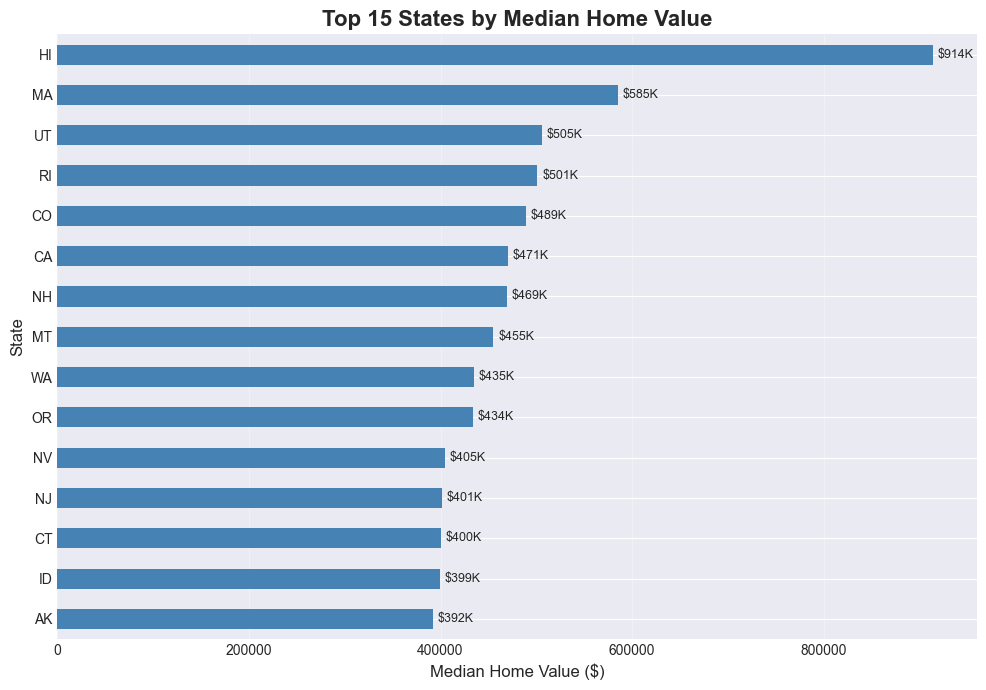

In [36]:
# Bar chart: Median home value by state (top 15 states)
top_states = (home_values_latest
              .groupby('StateName')['HomeValue']
              .median()
              .nlargest(15)
              .sort_values(ascending=True))

plt.figure(figsize=(10, 7))
top_states.plot(kind='barh', color='steelblue')
plt.title('Top 15 States by Median Home Value', fontsize=16, fontweight='bold')
plt.xlabel('Median Home Value ($)', fontsize=12)
plt.ylabel('State', fontsize=12)

# Add value labels — like Excel's data labels
for i, v in enumerate(top_states):
    plt.text(v + 5000, i, f'${v/1e6:.2f}M' if v > 1e6 else f'${v/1e3:.0f}K',
             va='center', fontsize=9)

plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

<Figure size 1200x600 with 0 Axes>

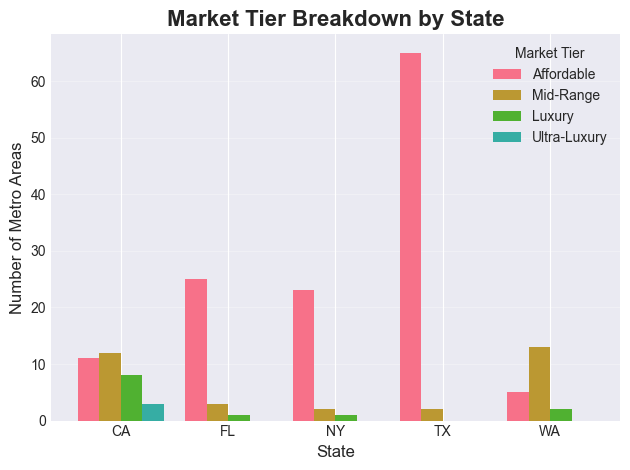

In [37]:
# Grouped bar chart: Market tier breakdown for select states
select_states = ['CA', 'TX', 'FL', 'NY', 'WA']
tier_by_state = (
    latest_home_values_copy[latest_home_values_copy['StateName'].isin(select_states)]
    .groupby(['StateName', 'MarketTier'])
    .size()
    .unstack(fill_value=0)
)

tier_order = ['Affordable', 'Mid-Range', 'Luxury', 'Ultra-Luxury']
tier_by_state = tier_by_state.reindex(columns=[c for c in tier_order if c in tier_by_state.columns])

plt.figure(figsize=(12, 6))
tier_by_state.plot(kind='bar', width=0.8)
plt.title('Market Tier Breakdown by State', fontsize=16, fontweight='bold')
plt.xlabel('State', fontsize=12)
plt.ylabel('Number of Metro Areas', fontsize=12)
plt.legend(title='Market Tier', fontsize=10)
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## Line Charts

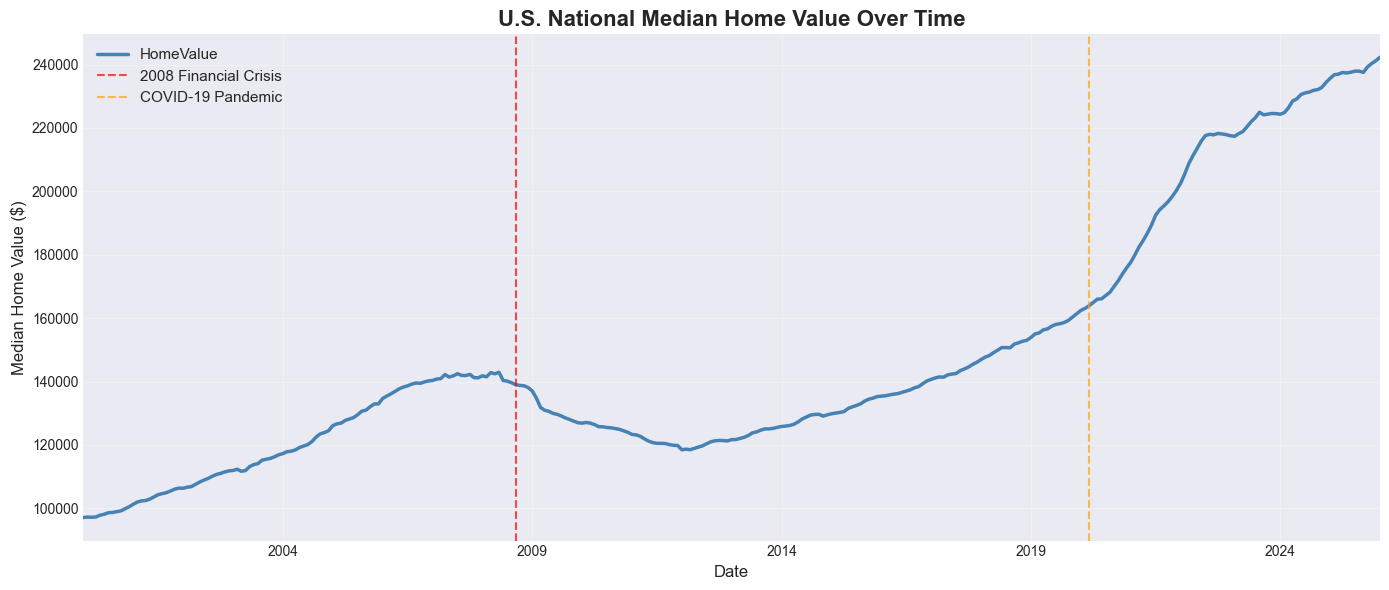

In [38]:
# Time series: National median home value over time
national_trend = home_values.groupby('Date')['HomeValue'].median()

plt.figure(figsize=(14, 6))
national_trend.plot(kind='line', linewidth=2.5, color='steelblue')

# Annotate key events (just like Excel text boxes)
plt.axvline(pd.Timestamp('2008-09-01'), color='red', linestyle='--', alpha=0.7, label='2008 Financial Crisis')
plt.axvline(pd.Timestamp('2020-03-01'), color='orange', linestyle='--', alpha=0.7, label='COVID-19 Pandemic')

plt.title('U.S. National Median Home Value Over Time', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Median Home Value ($)', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Top 5 metros by market size: ['United States', 'New York, NY', 'Los Angeles, CA', 'Chicago, IL', 'Dallas, TX']


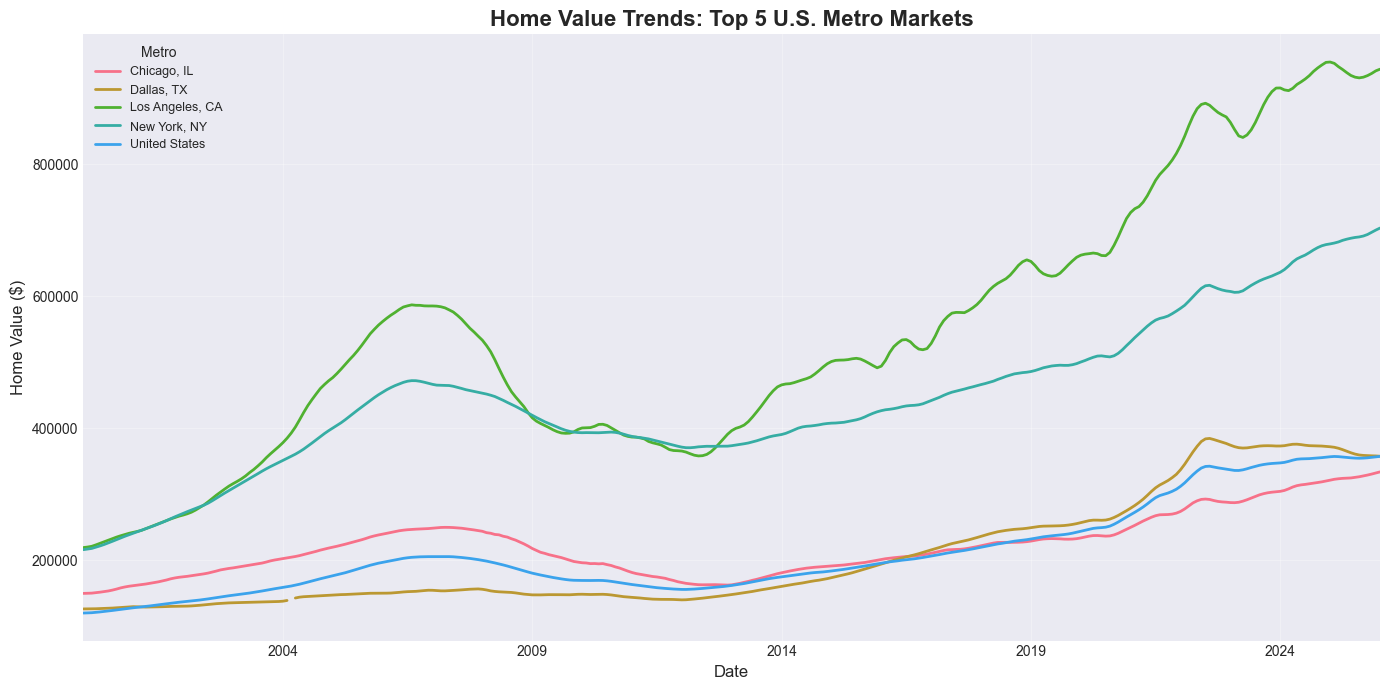

In [39]:
# Multiple lines: Home value trends for top 5 metros
top5_metros = home_values_latest.nsmallest(5, 'SizeRank')['RegionName'].tolist()
print(f"Top 5 metros by market size: {top5_metros}")

metro_trends = home_values[home_values['RegionName'].isin(top5_metros)].copy()
metro_pivot = metro_trends.pivot(index='Date', columns='RegionName', values='HomeValue')

plt.figure(figsize=(14, 7))
metro_pivot.plot(ax=plt.gca(), linewidth=2)
plt.title('Home Value Trends: Top 5 U.S. Metro Markets', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Home Value ($)', fontsize=12)
plt.legend(title='Metro', fontsize=9, loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [40]:
# Interactive: Pick any metros to compare
metro_trends_widget(home_values)

---

# Practice Exercises

Now it's your turn! Use the Zillow data to answer each question.

## Exercise 1: State-Level Filtering and Aggregation

Find all metro areas in **Texas (TX)** where the current median home value is above the **national median**. Display the results sorted by home value (descending).

*Hint: Calculate the national median first, then use boolean indexing with two conditions.*

**Guidelines**
- Compute the national median using `home_values_latest['HomeValue'].median()`.
- Filter `home_values_latest` to rows where `StateName == 'TX'` and `HomeValue` is greater than the national median.
- Sort the filtered result by `HomeValue` in descending order.
- Display a table with `RegionName` and `HomeValue`. 

In [41]:
# Your code here

# Step 1: Compute the national median home value
# national_median = home_values_latest[ ... ]
# print(f"National median home value: ${national_median:,.0f}")

# Step 2: Filter to Texas metros with HomeValue above the national median
# tx_above_national = home_values_latest[ ... ]

# Step 3: Sort by HomeValue (descending) and display RegionName and HomeValue
# tx_above_national = tx_above_national.sort_values( ... )
# display(tx_above_national[[ ... ]])

In [42]:
# Solution: Exercise 1

national_median = home_values_latest['HomeValue'].median()
print(f'National median home value: ${national_median:,.0f}')

tx_above_national = home_values_latest[
    (home_values_latest['StateName'] == 'TX') &
    (home_values_latest['HomeValue'] > national_median)
].sort_values('HomeValue', ascending=False)

print(f"\nTexas metros above national median: {len(tx_above_national)}")
display(tx_above_national[['RegionName', 'HomeValue']])

National median home value: $242,259

Texas metros above national median: 21


,RegionName,HomeValue
280053,"Fredericksburg, TX",494867.628557
279269,"Austin, TX",419518.286799
279812,"Kerrville, TX",358046.498897
279977,"Brenham, TX",357853.059339
279244,"Dallas, TX",357649.079207
279901,"Stephenville, TX",328252.126755
279486,"Midland, TX",320345.378856
279908,"Gainesville, TX",308615.618388
279245,"Houston, TX",302328.791293
279425,"College Station, TX",300625.666613


## Exercise 2: Pivot Table — Average Home Value by Market Tier and State

Create a pivot table showing the **average home value** for each **Market Tier** broken down by the **top 8 states** (by metro count). Add row/column margins.

*Hint: Use `latest_home_values_copy` which already has the `MarketTier` column.*

**Guidelines**
- Count metros per state and select the **top 8** states.
- Filter `latest_home_values_copy` to rows where `StateName` is in that top-8 list.
- Use `pivot_table` with:
  - `values='HomeValue'`
  - `index='StateName'`
  - `columns='MarketTier'`
  - `aggfunc='mean'`
  - `margins=True` for totals.
- Optionally round the result for nicer display.

In [43]:
# Your code here

# Step 1: Identify the top 8 states by metro count
# top8_states = ...

# Step 2: Filter latest_home_values_copy to only those top-8 states
# filtered = ...

# Step 3: Build a pivot table of average HomeValue by StateName and MarketTier
# pivot_ex2 = filtered.pivot_table(
#     values=...,  # column to aggregate
#     index=...,   # rows
#     columns=..., # columns
#     aggfunc=..., # aggregation function
#     fill_value=0,
#     margins=True,
# )

# Step 4: Optionally round and display the result
# pivot_ex2 = pivot_ex2.round(0)
# display(pivot_ex2)

In [44]:
# Solution: Exercise 2

top8_states = latest_home_values_copy['StateName'].value_counts().head(8).index

pivot_ex2 = latest_home_values_copy[latest_home_values_copy['StateName'].isin(top8_states)].pivot_table(
    values='HomeValue',
    index='StateName',
    columns='MarketTier',
    aggfunc='mean',
    fill_value=0,
    margins=True
).round(0)

print('Average home value by state and market tier:')
display(pivot_ex2)

Average home value by state and market tier:


MarketTier,Affordable,Luxury,Mid-Range,Ultra-Luxury,All
StateName,,,,,
CA,341266.0,878062.0,486112.0,1249931.0,598870.0
GA,229158.0,0.0,0.0,0.0,229158.0
IN,216018.0,0.0,0.0,0.0,216018.0
MI,229811.0,0.0,0.0,0.0,229811.0
NC,229691.0,0.0,453461.0,0.0,284122.0
OH,196211.0,0.0,0.0,0.0,196211.0
PA,223678.0,0.0,0.0,0.0,223678.0
TX,209281.0,0.0,457193.0,0.0,216681.0
All,221701.0,878062.0,470821.0,1249931.0,265655.0


## Exercise 3: Year-Over-Year Growth Chart

Plot the **annual median U.S. home value** as a line chart. Then add a second line showing the **year-over-year percent change**.

*Hint: Use `home_values.groupby('Year')` and `.pct_change()`.*

**Guidelines**
- Group `home_values` by `Year` and compute the median `HomeValue` for each year.
- Use `.pct_change()` on that annual series to compute YoY percent change.
- Create a figure with **two subplots** side by side using `plt.subplots(1, 2, ...)`.
- Plot the annual median values on the first subplot.
- Plot the YoY percent change on the second subplot (add a horizontal 0% line for reference).
- Add titles, axis labels, and grid lines for readability.

In [45]:
# Your code here

# Step 1: Aggregate to annual median home values
# annual_median = ...

# Step 2: Compute year-over-year percent change
# annual_growth = ...

# Step 3: Create a figure with two subplots side by side
# fig, (ax1, ax2) = plt.subplots(...)

# Step 4: Plot annual_median on the first axis
# annual_median.plot(ax=ax1, ...)
# ax1.set_title(...)
# ax1.set_ylabel(...)

# Step 5: Plot annual_growth on the second axis
# annual_growth.plot(ax=ax2, ...)
# ax2.axhline(y=0, ...)
# ax2.set_title(...)
# ax2.set_ylabel(...)

# Step 6: Format the layout
# plt.tight_layout()
# plt.show()

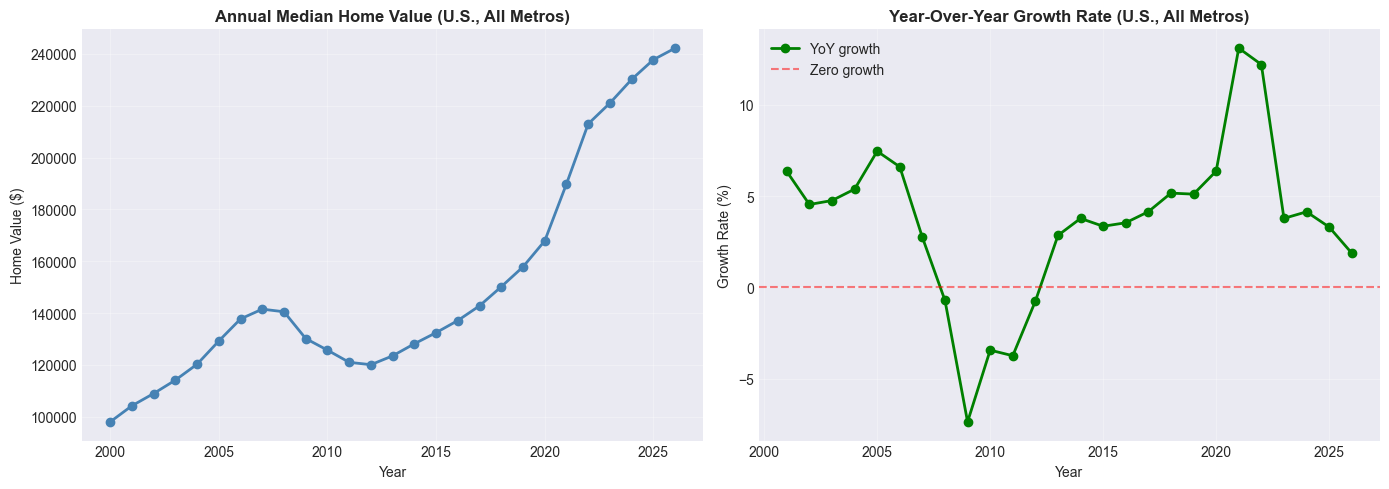

In [49]:
# Solution: Exercise 3

annual_median = home_values.groupby('Year')['HomeValue'].median()
annual_growth = annual_median.pct_change() * 100

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

annual_median.plot(ax=ax1, marker='o', linewidth=2, color='steelblue')
ax1.set_title('Annual Median Home Value (U.S., All Metros)', fontweight='bold')
ax1.set_ylabel('Home Value ($)')
ax1.grid(True, alpha=0.3)

annual_growth.plot(ax=ax2, marker='o', linewidth=2, color='green', label='YoY growth')
ax2.axhline(y=0, color='red', linestyle='--', alpha=0.5, label='Zero growth')
ax2.set_title('Year-Over-Year Growth Rate (U.S., All Metros)', fontweight='bold')
ax2.set_ylabel('Growth Rate (%)')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Exercise 4: Buy vs. Rent Analysis

Using `housing_combined`, classify metros into **'Lean Buy'**, **'Neutral'**, or **'Lean Rent'** based on their Price-to-Rent ratio (thresholds: < 15 = Buy, > 20 = Rent). Then create a bar chart showing the **count** of metros in each category, broken down by state (top 6 states by metro count).

*Hint: `housing_combined` already has `Buy_vs_Rent` and `Price_to_Rent` columns.*

**Guidelines**
- Identify the **top 6 states** by metro count in `housing_combined`.
- Filter to those states only.
- Group by `StateName` and `Buy_vs_Rent`, and use `.size()` to count metros in each combination.
- Use `.unstack()` so the buy/rent categories become columns.
- Plot the resulting table as a grouped bar chart with a clear title, axis labels, and legend.

In [47]:
# Your code here

# Step 1: Find the top 6 states by metro count
# top6 = ...

# Step 2: Filter housing_combined to those states
# ex4_data = ...

# Step 3: Group by StateName and Buy_vs_Rent and count metros
# tier_counts = (
#     ex4_data.groupby([ ... ])
#     .size()
#     .unstack(fill_value=0)
# )

# Step 4: Plot the grouped bar chart
# plt.figure(...)
# tier_counts.plot(kind='bar', ...)
# plt.title(...)
# plt.xlabel(...)
# plt.ylabel(...)
# plt.xticks(...)
# plt.legend(...)
# plt.grid(...)
# plt.tight_layout()
# plt.show()

<Figure size 1200x600 with 0 Axes>

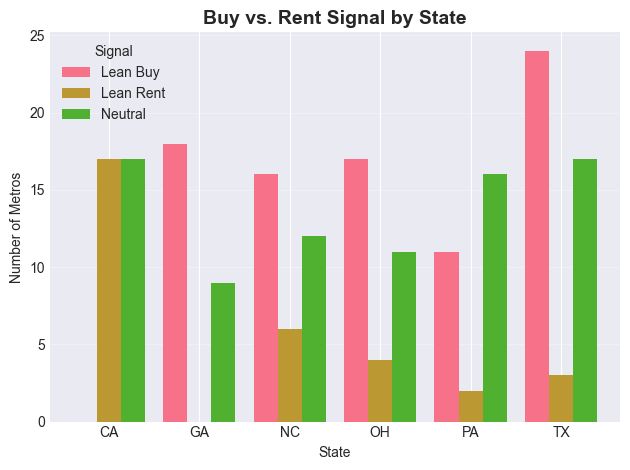

In [48]:
# Solution: Exercise 4

top6 = housing_combined['StateName'].value_counts().head(6).index
ex4_data = housing_combined[housing_combined['StateName'].isin(top6)]

tier_counts = (
    ex4_data.groupby(['StateName', 'Buy_vs_Rent'])
    .size()
    .unstack(fill_value=0)
)

plt.figure(figsize=(12, 6))
tier_counts.plot(kind='bar', width=0.8)
plt.title('Buy vs. Rent Signal by State', fontsize=14, fontweight='bold')
plt.xlabel('State')
plt.ylabel('Number of Metros')
plt.xticks(rotation=0)
plt.legend(title='Signal')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

---

# Conclusion

Congratulations! You've translated your Excel skills into Pandas using **real Zillow housing market data**. Here's a summary of what you covered:

## Key Takeaways:

1. **Wide → Long format**: `pd.melt()` is Excel's "Unpivot" — essential for time series data like home_values
2. **VLOOKUP → merge()**: Join datasets with flexible left/inner/outer options
3. **FILTER → Boolean Indexing**: Filter rows programmatically with `&`, `|`, `.isin()`
4. **SUMIF/COUNTIF → groupby()**: Aggregate across all groups in one line
5. **IF Statements → np.where() / apply()**: Create conditional columns at scale
6. **Pivot Tables → pivot_table()**: Summarize data with row/column/value dimensions
7. **Charts → matplotlib/seaborn**: Reproducible, annotatable, publication-quality plots

## Why Pandas > Excel for This Kind of Data:

✅ **Scalability**: The home_values dataset has 300+ metros × 280+ months = 80,000+ data points — trivial for pandas, painful in Excel

✅ **Reproducibility**: Every transformation is documented in code

✅ **Automation**: Re-run this notebook every month as new data is released with zero manual effort

✅ **Live Data**: Load directly from a URL — no manual downloading required

## Next Steps:

- Explore the full [Zillow Research data catalog](https://www.zillow.com/research/data/) for other datasets
- Learn time series forecasting with `statsmodels` or `prophet`
- Build a regression model to predict home values using `scikit-learn`
- Automate a monthly housing report using Jupyter and pandas

## Resources:

- [Pandas Documentation](https://pandas.pydata.org/docs/)
- [Zillow Research Data](https://www.zillow.com/research/data/)
- [Python Data Science Handbook](https://jakevdp.github.io/PythonDataScienceHandbook/)

## Quick Reference Cheat Sheet

| Excel Function | Pandas Equivalent | Zillow Example |
|---------------|------------------|----------------|
| File → Open CSV | `pd.read_csv(url)` | `pd.read_csv(home_values_URL)` |
| Data → Unpivot | `pd.melt()` | Wide home_values → long format |
| VLOOKUP | `df.merge()` | Join home_values + rent_values by RegionName |
| VLOOKUP (1 col) | `series.map(dict)` | Map RegionName → home value |
| AutoFilter | Boolean indexing | `df[df['StateName'] == 'CA']` |
| FILTER (multi-value) | `.isin()` | `df[df['State'].isin(['CA','NY'])]` |
| SUMIF | `groupby().sum()` | Total value by state |
| AVERAGEIF | `groupby().mean()` | Avg home value by tier |
| COUNTIF | `value_counts()` | Count of metros per state |
| IF | `np.where()` | Classify Affordable vs Expensive |
| Nested IFS | `np.select()` | Multi-tier market classification |
| IF (complex) | `.apply(func)` | Custom categorization logic |
| =(B-A)/A | `.pct_change()` | Year-over-year home value growth |
| PivotTable | `pivot_table()` | Value by state × tier |
| Insert → Chart | `df.plot()` | Time series, bar charts |
| AVERAGE | `.mean()` | Mean home value nationally |
| MAX/MIN | `.max()` / `.min()` | Most/least expensive metro |

**Congratulations on completing From Excel to Pandas: Housing Market Edition!** 🎉

You're now equipped to work with large, real-world datasets — the same data used by housing economists, mortgage analysts, and real estate investors. Keep practicing!

*Happy coding!* 🐍📊